In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
df = pd.read_csv("nova_pay_combined.csv")

In [6]:
df.head()

,transaction_id,customer_id,timestamp,home_country,source_currency,dest_currency,channel,amount_src,amount_usd,fee,...,ip_risk_score,kyc_tier,account_age_days,device_trust_score,chargeback_history_count,risk_score_internal,txn_velocity_1h,txn_velocity_24h,corridor_risk,is_fraud
0,fee8542d-8ee6-4b0d-9671-c294dd08ed26,402cccc9-28de-45b3-9af7-cc5302aa1f93,2022-10-03 18:40:59.468549+00:00,US,USD,CAD,ATM,278.19,278.19,4.25,...,0.123,standard,263,0.522,0,0.223,0,0,0.0,0
1,bfdb9fc1-27fe-4a85-b043-4d813d679259,67c2c6b3-ef0a-4777-a3f1-c84a851bb6ad,2022-10-03 20:39:38.468549+00:00,CA,CAD,MXN,web,208.51,154.29,4.24,...,0.569,standard,947,0.475,0,0.268,0,1,0.0,0
2,fc855034-3ea5-4993-9afa-b511d93fe5e8,6d0d9b27-fa26-45f8-93b1-2df29d182d9c,2022-10-03 23:02:43.468549+00:00,US,USD,CNY,mobile,160.33,160.33,2.70,...,0.437,enhanced,367,0.939,0,0.176,0,0,0.0,0
3,2cf8c08e-42ec-444d-a755-34b9a2a0a4ca,7bd5200c-5d19-44f0-9afe-8b339a05366b,2022-10-04 01:08:53.468549+00:00,US,USD,EUR,mobile,59.41,59.41,2.22,...,0.594,standard,147,0.551,0,0.391,0,0,0.0,0
4,d907a74d-b426-438d-97eb-dbe911aca91c,70a93d26-8e3a-4179-900c-a4a7a74d08e5,2022-10-04 09:35:03.468549+00:00,US,USD,INR,mobile,200.96,200.96,3.61,...,0.121,enhanced,257,0.894,0,0.257,0,0,0.0,0


In [7]:
df.shape

(11400, 26)

In [8]:
df.isnull().sum()

transaction_id                 0
customer_id                    0
timestamp                     29
home_country                   0
source_currency                0
dest_currency                  0
channel                        0
amount_src                     0
amount_usd                   305
fee                          295
exchange_rate_src_to_dest      0
device_id                      0
new_device                     0
ip_address                   305
ip_country                   301
location_mismatch              0
ip_risk_score                  0
kyc_tier                     300
account_age_days               0
device_trust_score           295
chargeback_history_count       0
risk_score_internal            0
txn_velocity_1h                0
txn_velocity_24h               0
corridor_risk                  0
is_fraud                       0
dtype: int64

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11400 entries, 0 to 11399
Data columns (total 26 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   transaction_id             11400 non-null  object 
 1   customer_id                11400 non-null  object 
 2   timestamp                  11371 non-null  object 
 3   home_country               11400 non-null  object 
 4   source_currency            11400 non-null  object 
 5   dest_currency              11400 non-null  object 
 6   channel                    11400 non-null  object 
 7   amount_src                 11400 non-null  object 
 8   amount_usd                 11095 non-null  float64
 9   fee                        11105 non-null  float64
 10  exchange_rate_src_to_dest  11400 non-null  float64
 11  device_id                  11400 non-null  object 
 12  new_device                 11400 non-null  bool   
 13  ip_address                 11095 non-null  obj

In [10]:
# Check distribution of target variable
df["is_fraud"].value_counts(normalize=True)

is_fraud
0    0.912544
1    0.087456
Name: proportion, dtype: float64

DATA CLEANING 
This cell ensures proper data types:
1. Converts timestamp to datetime, coercing invalid values to NaT
2. Converts amount_src to numeric(float), setting non-numeric values to NaN

In [11]:
# Convert timestamp column 
df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')

# convert amount_src to float (remove possible commas or non-numeric issues)
df['amount_src'] = pd.to_numeric(df['amount_src'], errors='coerce')

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11400 entries, 0 to 11399
Data columns (total 26 columns):
 #   Column                     Non-Null Count  Dtype              
---  ------                     --------------  -----              
 0   transaction_id             11400 non-null  object             
 1   customer_id                11400 non-null  object             
 2   timestamp                  11339 non-null  datetime64[ns, UTC]
 3   home_country               11400 non-null  object             
 4   source_currency            11400 non-null  object             
 5   dest_currency              11400 non-null  object             
 6   channel                    11400 non-null  object             
 7   amount_src                 11396 non-null  float64            
 8   amount_usd                 11095 non-null  float64            
 9   fee                        11105 non-null  float64            
 10  exchange_rate_src_to_dest  11400 non-null  float64            
 11  de

This cell calculates exchange rates per currency:
1. Selects row where amount_currency is present.
2. Groups by source_currency.
3. Computes the mean of amount_usd / amount_src for each currency.
4. Converts the results to a dictionary for easy lookup.

In [13]:
exchange_rates = df[df['amount_usd'].notna()].groupby('source_currency').apply(
    lambda x: (x['amount_usd'] / x['amount_src']).mean()
).to_dict()

C:\Users\lapto\AppData\Local\Temp\ipykernel_20020\3405045531.py:1: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  exchange_rates = df[df['amount_usd'].notna()].groupby('source_currency').apply(


In [14]:
df["source_currency"].value_counts()

source_currency
USD    8031
GBP    2139
CAD    1230
Name: count, dtype: int64

In [15]:
exchange_rates

{'CAD': 0.7216095926871465,
 'GBP': 1.223441221648679,
 'USD': 0.9838730321259439}

This cell fills missing amount_usd values:
1. If amount_usd is already present, keep it.
2. otherwise, calculate it using amount_src multiplied by the exchange rate for that source_currency.
3. Defaults to 1 if the currency is not in exchange_rates.

In [16]:
df['amount_usd'] = df.apply(
    lambda row: row['amount_usd'] if pd.notna(row['amount_usd']) else row['amount_src'] * exchange_rates.get(row['source_currency'], 1),
    axis=1
)

This cell fills missing fee values:
1. if channel exists, fill missing fee per channel using the channel's median.
2. Then fill any remaining  fee using the overall median.

In [17]:
# fee: median (or by channel if present)
if 'fee' in df.columns:
    if 'channel' in df.columns:
        df['free'] = df.groupby('channel')['fee'].transform(lambda s: s.fillna(s.median()))
        df['fee'] = df['fee'].fillna(df['free'].median())

This cell fills missing ip_country values:

if ip_country is missing, it uses the corresponding home_country as a feedback.

In [18]:
# ip_country: fallback to home_country
if {'ip_country', 'home_country'}.issubset(df.columns):
    df['ip_country'] = df['ip_country'].fillna(df['home_country'])

This cell fills missing kyc_tier values:
1. Finds the most frequent kyc_tier (mode)
2. Fills missing values with this mode/default.

In [19]:
# kyc_tier: fill with mode 
if 'kyc_tier' in df.columns:
    mode_kyc = df['kyc_tier'].mode().iloc[0] if not df['kyc_tier'].mode().empty else 'standard'
    df['kyc_tier'] = df['kyc_tier'].fillna(mode_kyc)

This cell fill missing device_trust_score values:
1. If new_device and kyc_tier exist, fill missing scores per group using the group's median.
2. Then fill any remaining missing scores with the overall median.

In [20]:
if 'device_trust_score' in df.columns:
    if {'new_device','kyc_tier'}.issubset(df.columns):
        df['device_trust_score'] = df.groupby(['new_device','kyc_tier'])['device_trust_score'] \
                                       .transform(lambda s: s.fillna(s.median()))
    df['device_trust_score'] = df['device_trust_score'].fillna(df['device_trust_score'].median())

In [21]:
df.dropna(inplace=True  )

In [22]:
df.isna().sum()

transaction_id               0
customer_id                  0
timestamp                    0
home_country                 0
source_currency              0
dest_currency                0
channel                      0
amount_src                   0
amount_usd                   0
fee                          0
exchange_rate_src_to_dest    0
device_id                    0
new_device                   0
ip_address                   0
ip_country                   0
location_mismatch            0
ip_risk_score                0
kyc_tier                     0
account_age_days             0
device_trust_score           0
chargeback_history_count     0
risk_score_internal          0
txn_velocity_1h              0
txn_velocity_24h             0
corridor_risk                0
is_fraud                     0
free                         0
dtype: int64

Sanity check for Fraud Detection on the Dataset

In [23]:
# count negative values in key numeric columns
neg_counts = {
    'amount_src': (df['amount_src'] < 0).sum(),
    'amount_usd': (df['amount_usd'] < 0).sum(),
    'fee': (df['fee'] < 0).sum(),
    'device_trust_score': (df['device_trust_score'] < 0).sum(),
    'txn_velocity_1h': (df['txn_velocity_1h'] < 0).sum(),
    'txn_velocity_24h': (df['txn_velocity_24h'] < 0).sum(),
    'risk_score_internal': (df['risk_score_internal'] < 0).sum(),
}

neg_counts

{'amount_src': np.int64(100),
 'amount_usd': np.int64(0),
 'fee': np.int64(90),
 'device_trust_score': np.int64(190),
 'txn_velocity_1h': np.int64(190),
 'txn_velocity_24h': np.int64(0),
 'risk_score_internal': np.int64(0)}

In [24]:
df = df[
    (df['amount_src'] >= 0) &
    (df['fee'] >= 0) &
    (df['device_trust_score'] >= 0)
]

In [25]:
(df['amount_usd'] / df['amount_src']).describe()

count    10840.000000
mean         1.018123
std          0.136521
min          0.739788
25%          1.000000
50%          1.000000
75%          1.000000
max          1.250405
dtype: float64

In [26]:
df[df['timestamp'] > pd.Timestamp.utcnow()]

,transaction_id,customer_id,timestamp,home_country,source_currency,dest_currency,channel,amount_src,amount_usd,fee,...,kyc_tier,account_age_days,device_trust_score,chargeback_history_count,risk_score_internal,txn_velocity_1h,txn_velocity_24h,corridor_risk,is_fraud,free


In [27]:
# Remove rows where timestamp is in the future
df = df[df['timestamp'] <= pd.Timestamp.utcnow()]

In [28]:
df['location_mismatch'].value_counts()

location_mismatch
False    9047
True     1793
Name: count, dtype: int64

In [29]:
df['channel'].unique()
df['source_currency'].unique()
df['dest_currency'].unique()
df['kyc_tier'].unique()

array(['standard', 'enhanced', 'low', ' standard  ', 'standrd',
       ' enhanced  ', 'STANDARD', 'unknown', 'enhancd', ' low  ',
       'ENHANCED', 'LOW'], dtype=object)

In [30]:
df['source_currency'].unique()

array(['USD', 'CAD', 'GBP'], dtype=object)

In [31]:
df['channel'].unique()

array(['ATM', 'web', 'mobile', 'WEB', ' web  ', 'MOBILE', 'unknown',
       'mobille', ' mobile  ', 'weeb', 'ATm', ' ATM  '], dtype=object)

In [32]:
df['dest_currency'].unique()

array(['CAD', 'MXN', 'CNY', 'EUR', 'INR', 'GBP', 'PHP', 'NGN', 'USD'],
      dtype=object)

In [33]:
df['kyc_tier'].unique()

array(['standard', 'enhanced', 'low', ' standard  ', 'standrd',
       ' enhanced  ', 'STANDARD', 'unknown', 'enhancd', ' low  ',
       'ENHANCED', 'LOW'], dtype=object)

In [34]:
df['channel'] = df['channel'].str.lower().str.strip()

In [35]:
df['channel'] = df['channel'].replace({
    'web': 'web',
    'weeb': 'web',

    'mobile': 'mobile',
    'mobille': 'mobile',

    'atm': 'atm',
})

In [36]:
df['kyc_tier'] = df['kyc_tier'].str.lower().str.strip()

In [37]:
df['kyc_tier'] = df['kyc_tier'].replace({
    'standard': 'standard',
    'standrd': 'standard',

    'low': 'low',
    'enhanced': 'enhanced',

    'enhancd': 'enhanced',
})

In [38]:
df['channel'] = df['channel'].replace({'unknown': np.nan})

In [39]:
df['kyc_tier'] = df['kyc_tier'].replace({'unknown': np.nan})

In [40]:
df.isna().sum()

transaction_id                0
customer_id                   0
timestamp                     0
home_country                  0
source_currency               0
dest_currency                 0
channel                      36
amount_src                    0
amount_usd                    0
fee                           0
exchange_rate_src_to_dest     0
device_id                     0
new_device                    0
ip_address                    0
ip_country                    0
location_mismatch             0
ip_risk_score                 0
kyc_tier                     29
account_age_days              0
device_trust_score            0
chargeback_history_count      0
risk_score_internal           0
txn_velocity_1h               0
txn_velocity_24h              0
corridor_risk                 0
is_fraud                      0
free                          0
dtype: int64

In [41]:
df.dropna(inplace=True)

EDA & Feature Engineering 

1. Target Inspection
* Check is_fraud class balance to assess imbalance 
2. Univarity EDA
* Numeric: amount, fee, scores, velocities - distribution, outliers.
* Categorical: channel, currencies, countries, kyc_tier - counts.
3. Bivariate EDA
* Fruad rate by channel, country, kyc_tier, time-of-day.
4. Feature Engineering 
* Time-bassed: hour, day-of-week,weekend.
* Amount-based: log(amount),fee_rate, high-risk flags.
* Behavioural: velocity ratios, flags from historical behavior.
* Categorical: one-hot, ordinal, or target encoding.

In [42]:
df.corr(numeric_only=True)["is_fraud"].sort_values(ascending=False)

is_fraud                     1.000000
txn_velocity_24h             0.759866
txn_velocity_1h              0.698681
risk_score_internal          0.612653
ip_risk_score                0.591583
chargeback_history_count     0.585117
location_mismatch            0.428793
new_device                   0.389261
corridor_risk                0.198449
exchange_rate_src_to_dest    0.154757
amount_usd                   0.131411
amount_src                   0.130744
fee                          0.130538
free                         0.130538
account_age_days            -0.291430
device_trust_score          -0.440364
Name: is_fraud, dtype: float64

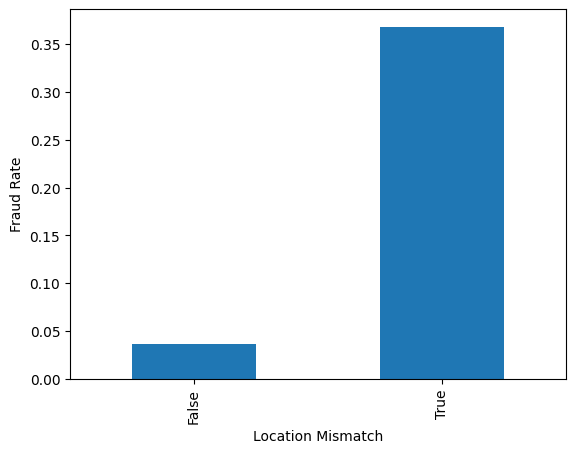

In [43]:
df.groupby("location_mismatch")["is_fraud"].mean().plot.bar()
plt.ylabel("Fraud Rate")
plt.xlabel("Location Mismatch")
plt.show()

In [44]:
cat_cols = df.select_dtypes(include=['object', 'category']).columns
cat_cols

Index(['transaction_id', 'customer_id', 'home_country', 'source_currency',
       'dest_currency', 'channel', 'device_id', 'ip_address', 'ip_country',
       'kyc_tier'],
      dtype='object')

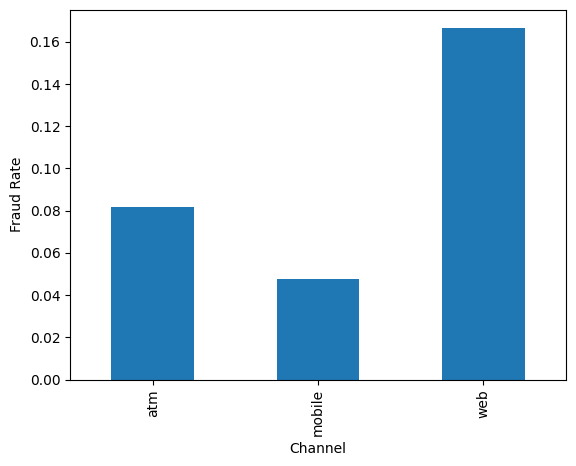

In [45]:
df.groupby("channel")["is_fraud"].mean().plot.bar()
plt.ylabel("Fraud Rate")
plt.xlabel("Channel")
plt.show()

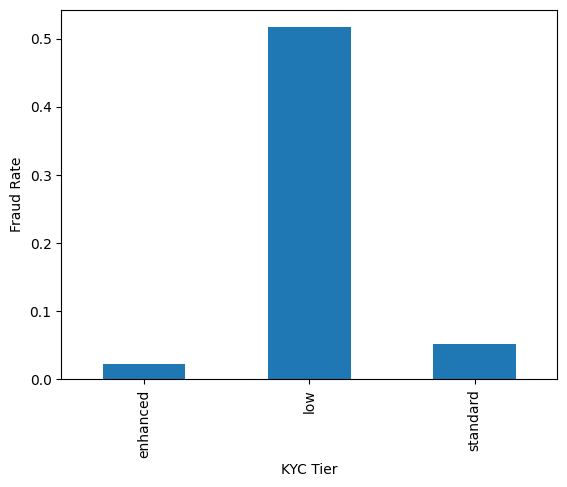

In [46]:
df.groupby("kyc_tier")["is_fraud"].mean().plot.bar()
plt.ylabel("Fraud Rate")
plt.xlabel("KYC Tier")
plt.show()

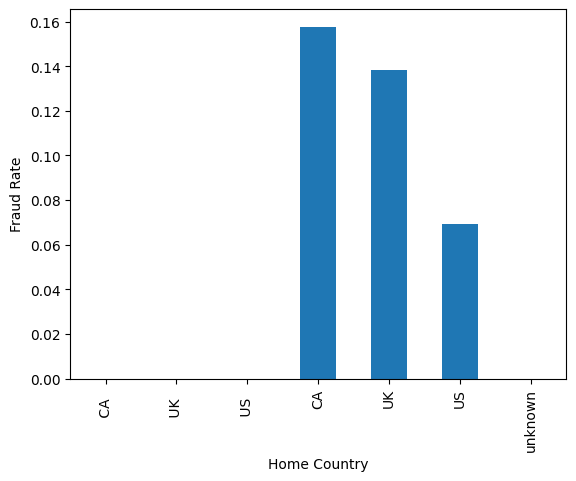

In [47]:
df.groupby("home_country")["is_fraud"].mean().plot.bar()
plt.ylabel("Fraud Rate")
plt.xlabel("Home Country")
plt.show()

In [48]:
df['home_country'] =df['home_country'].str.lower().str.strip()

Features Engineering

What this code does
* Extracts the hour, day of week, and weekend indictor from the timestamp column.
* Hour Shows the time of day (0-23).
* Day_of_week shows which day it is (0 = Monday_6 = Sunday).
* is_weekend becomes 1 for Saturday/Seunday, else 0.
* The prints show the new columns and a distribution of hours


In [49]:
# Extract time-based features
df['hour'] = df['timestamp'].dt.hour
df['day_of_week'] = df['timestamp'].dt.dayofweek # 0-Monday, 6-Sunday
df['is_weekend'] = (df['day_of_week'] >= 5).astype(int)

print("Time features created:")
print(df[['timestamp', 'hour', 'day_of_week', 'is_weekend']].head())
print("\nHour distribution:")
print(df['hour'].value_counts().sort_index())

Time features created:
                         timestamp  hour  day_of_week  is_weekend
0 2022-10-03 18:40:59.468549+00:00    18            0           0
1 2022-10-03 20:39:38.468549+00:00    20            0           0
2 2022-10-03 23:02:43.468549+00:00    23            0           0
3 2022-10-04 01:08:53.468549+00:00     1            1           0
4 2022-10-04 09:35:03.468549+00:00     9            1           0

Hour distribution:
hour
0     452
1     398
2     413
3     480
4     503
5     471
6     464
7     439
8     471
9     425
10    444
11    424
12    447
13    444
14    413
15    467
16    461
17    422
18    467
19    491
20    434
21    423
22    450
23    477
Name: count, dtype: int64


fraud_by_hour


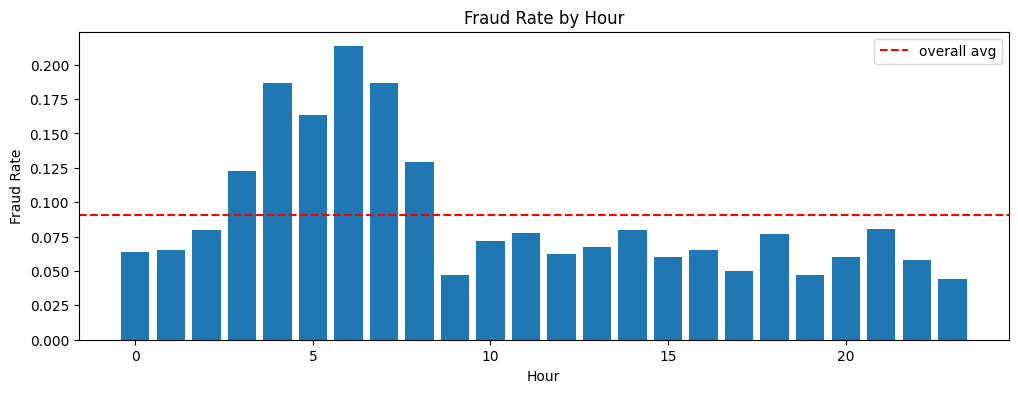

In [50]:
# Fraud rate by hour
Fraud_by_hour = df.groupby('hour')['is_fraud'].mean()

print('fraud_by_hour')

plt.figure(figsize=(12, 4))
plt.bar(Fraud_by_hour.index, Fraud_by_hour.values)
plt.xlabel('Hour')
plt.ylabel('Fraud Rate')
plt.title('Fraud Rate by Hour')
plt.axhline(y=df['is_fraud'].mean(), color='r', linestyle='--', label='overall avg')
plt.legend()
plt.show()

What this code does
  * Creates account age buckets (e.g., <30d, 30-90d, etc.) using pg.cut based on account_age_days.
  * Computes the fraud rate for each age bucket by talking the means of is_fraud.
  * Plots a bar chart showing fraud rate per age category.
  * Draws a red dashed line showing the overall fraud rate so you can compare each bauket against the global average. 

age_bucket
<30d        0.368681
30-90d      0.442584
90-180d     0.023736
180-365d    0.016901
>1yr        0.010534
Name: is_fraud, dtype: float64


C:\Users\lapto\AppData\Local\Temp\ipykernel_20020\282900610.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  fraud_by_age = df.groupby('age_bucket')['is_fraud'].mean()


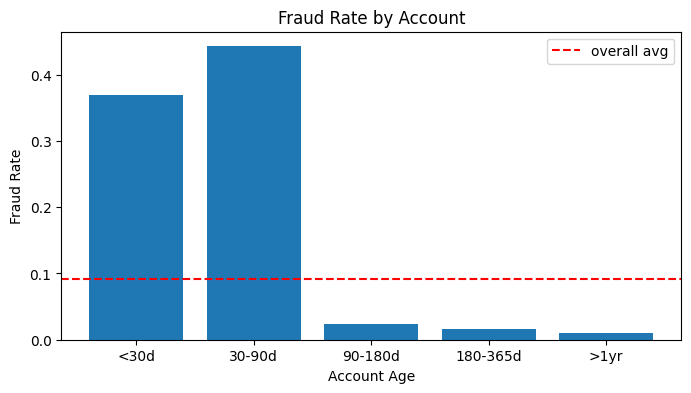

In [51]:
# Fraud rate by account age bucket
df['age_bucket'] = pd.cut(df['account_age_days'],
                         bins=[0, 30, 90, 180, 365, 2000],
                         labels=['<30d', '30-90d', '90-180d', '180-365d', '>1yr'])

fraud_by_age = df.groupby('age_bucket')['is_fraud'].mean()
print(fraud_by_age)

plt.figure(figsize=(8, 4))
plt.bar(range(len(fraud_by_age)), fraud_by_age.values)
plt.xticks(range(len(fraud_by_age)), fraud_by_age.index)
plt.xlabel('Account Age')
plt.ylabel('Fraud Rate')
plt.title('Fraud Rate by Account')
plt.axhline(y=df['is_fraud'].mean(), color='r', linestyle='--', label='overall avg')
plt.legend()
plt.show()


txn_velocity_1h
0    0.017459
1    0.000000
2    0.000000
3    0.835878
4    0.842324
5    0.801047
6    0.700000
7    0.702703
8    0.482759
Name: is_fraud, dtype: float64


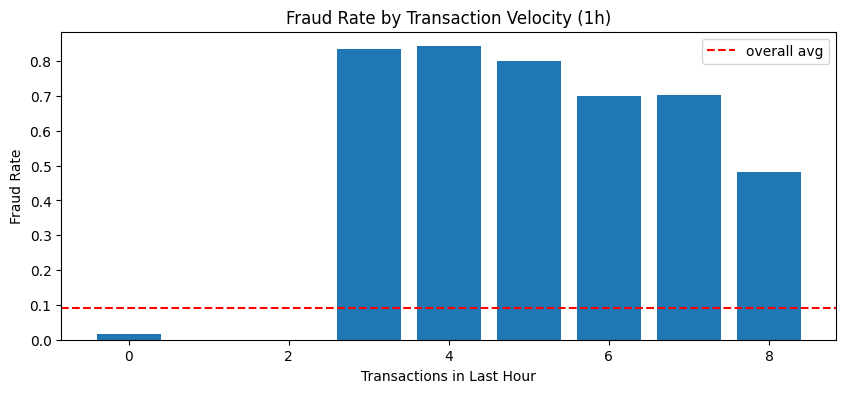

In [52]:
# Fraud rate by velocity (transactions in last hour)
fraud_by_velocity = df.groupby('txn_velocity_1h')['is_fraud'].mean()
print(fraud_by_velocity)

plt.figure(figsize=(10, 4))
plt.bar(fraud_by_velocity.index, fraud_by_velocity.values)
plt.xlabel('Transactions in Last Hour')
plt.ylabel('Fraud Rate')
plt.title('Fraud Rate by Transaction Velocity (1h)')
plt.axhline(y=df['is_fraud'].mean(), color='r', linestyle='--', label='overall avg')
plt.legend()
plt.show()


amount_bucket
<$100       0.017952
$100-500    0.061642
$500-1k     0.301768
$1k-2k      0.676806
$2k-5k      0.943820
>$50k       0.140909
Name: is_fraud, dtype: float64


C:\Users\lapto\AppData\Local\Temp\ipykernel_20020\1009657064.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  fraud_by_amount = df.groupby('amount_bucket')['is_fraud'].mean()


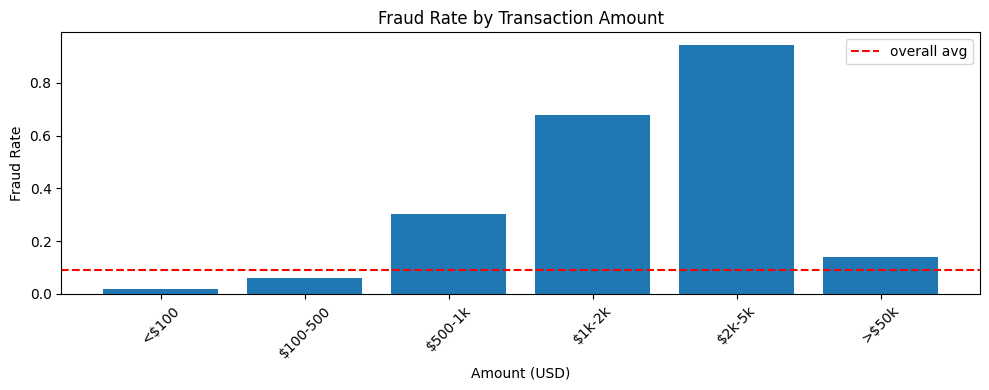

In [53]:
# Fraud rate by amount buckets
df['amount_bucket'] = pd.cut(df['amount_usd'],
                             bins=[0, 100, 500, 1000, 2000, 5000, 20000],
                             labels=['<$100', '$100-500', '$500-1k', '$1k-2k', '$2k-5k', '>$50k'])

fraud_by_amount = df.groupby('amount_bucket')['is_fraud'].mean()
print(fraud_by_amount)

plt.figure(figsize=(10, 4))
plt.bar(range(len(fraud_by_amount)), fraud_by_amount.values)
plt.xticks(range(len(fraud_by_amount)), fraud_by_amount.index, rotation=45)
plt.xlabel('Amount (USD)')
plt.ylabel('Fraud Rate')
plt.title('Fraud Rate by Transaction Amount')
plt.axhline(y=df['is_fraud'].mean(), color='r', linestyle='--', label='overall avg')
plt.legend()
plt.tight_layout()
plt.show()

C:\Users\lapto\AppData\Local\Temp\ipykernel_20020\3487139991.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  fraud_by_amount = df.groupby('ip_risk_bucket')['is_fraud'].mean()


ip_risk_bucket
Low<0.3     0.014604
0.3-0.5     0.022482
0.5-0.7     0.029552
0.7-0.8     0.194245
High>0.8    0.625707
Name: is_fraud, dtype: float64


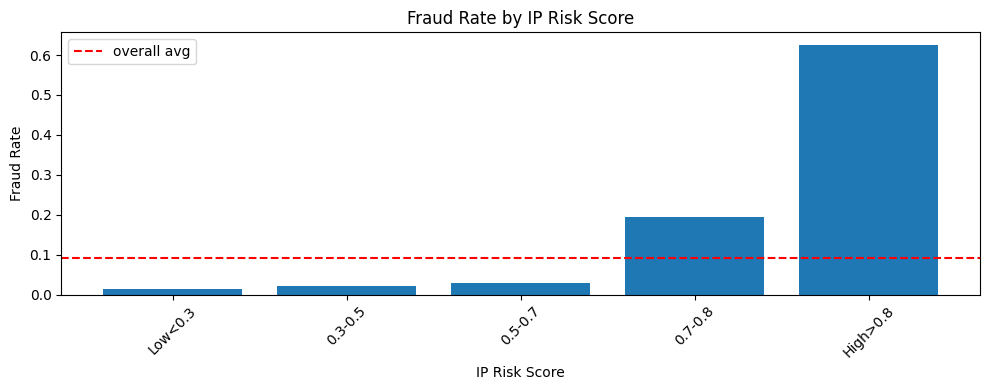

In [54]:
# Fraud rate by IP risk bucket
df['ip_risk_bucket'] = pd.cut(df['ip_risk_score'],
                             bins=[0, 0.3, 0.5, 0.7, 0.8, 1.0],
                             labels=['Low<0.3', '0.3-0.5', '0.5-0.7', '0.7-0.8', 'High>0.8'])

fraud_by_amount = df.groupby('ip_risk_bucket')['is_fraud'].mean()
print(fraud_by_amount)

plt.figure(figsize=(10, 4))
plt.bar(range(len(fraud_by_amount)), fraud_by_amount.values)
plt.xticks(range(len(fraud_by_amount)), fraud_by_amount.index, rotation=45)
plt.xlabel('IP Risk Score')
plt.ylabel('Fraud Rate')
plt.title('Fraud Rate by IP Risk Score')
plt.axhline(y=df['is_fraud'].mean(), color='r', linestyle='--', label='overall avg')
plt.legend()
plt.tight_layout()
plt.show()

In [55]:
# Based on our analysis, create threshold-based features
df['night_hours'] = ((df['hour'] >= 3) & (df['hour'] <= 7)).astype(int)
df['account_very_new'] = (df['account_age_days'] < 30).astype(int)
df['account_new'] = (df['account_age_days'] >= 30) & (df['account_age_days'] < 90).astype(int)
df['velocity_burst'] = (df['txn_velocity_1h'] >= 3).astype(int)
df['amount_high'] = (df['amount_usd'] >= 2000).astype(int)
df['ip_risk_high'] = (df['ip_risk_score'] >= 0.8).astype(int)
df['device_low_trust'] = (df['device_trust_score'] < 0.5).astype(int)

print("feature created:")
print(df[['night_hours', 'account_very_new', 'velocity_burst', 'amount_high',
        'ip_risk_high', 'device_low_trust']].describe())

feature created:
        night_hours  account_very_new  velocity_burst   amount_high  \
count  10780.000000      10780.000000    10780.000000  10780.000000   
mean       0.218646          0.168275        0.098516      0.028664   
std        0.413347          0.374127        0.298025      0.166869   
min        0.000000          0.000000        0.000000      0.000000   
25%        0.000000          0.000000        0.000000      0.000000   
50%        0.000000          0.000000        0.000000      0.000000   
75%        0.000000          0.000000        0.000000      0.000000   
max        1.000000          1.000000        1.000000      1.000000   

       ip_risk_high  device_low_trust  
count  10780.000000      10780.000000  
mean       0.115028          0.231725  
std        0.319070          0.421954  
min        0.000000          0.000000  
25%        0.000000          0.000000  
50%        0.000000          0.000000  
75%        0.000000          0.000000  
max        1.000000    

In [56]:
# Drop temporary bucket columns if they exist (avoid KeyError)
df = df.drop(
    ['age_bucket', 'amount_bucket', 'ip_risk_bucket', 'device_trust_bucket'],
    axis=1,
    errors='ignore'
)

# Define feature sets (use actual column names present in df)
categorical_features = ['channel', 'kyc_tier', 'home_country', 'source_currency',
                        'dest_currency', 'ip_country', 'new_device', 'location_mismatch']

numeric_features = ['amount_src', 'amount_usd', 'fee', 'ip_risk_score',
                      'device_trust_score', 'account_age_days', 'txn_velocity_1h',
                      'txn_velocity_24h', 'corridor_risk', 'risk_score_internal',
                      'hour', 'day_of_week', 'is_weekend', 'night_hours',
                      'account_very_new', 'account_new', 'velocity_burst',
                      'amount_high', 'ip_risk_high', 'device_low_trust']

all_features = categorical_features + numeric_features

# Remove any features that are not actually in df to prevent KeyError later
missing = [c for c in all_features if c not in df.columns]
if missing:
    print("Warning: removing missing features from all_features:", missing)
all_features = [c for c in all_features if c in df.columns]

print(f"Total features: {len(all_features)}")
print(f" Categorical: {len(categorical_features)}")
print(f" Numeric: {len(numeric_features)}")
print(f"\nDataset shape: {df.shape}")

Total features: 28
 Categorical: 8
 Numeric: 20

Dataset shape: (10780, 37)


Modelling

What this code does
*  Sort the dataframe chronologically by timestamp to avoid data leakage.
      * Splits the data into 80% training and 20% testing based on time order.
      * Prints the number of rows, fraud counts, and fraud rates for both splits
      * Seprates the features matrix (x_train, x_test) from the target labels (y_test).
      * Shows the shapes of all the resulting datasets to confirm everythings matches.

In [57]:
# Sort by timestamp for chronological split 
df = df.sort_values(by='timestamp').reset_index(drop=True)

# 80/20 times-based split
split_index = int(len(df) * 0.8)
train_df = df.iloc[:split_index].copy()
test_df = df.iloc[split_index:].copy()
print(f"Train: {len(train_df)}, rows ({train_df['is_fraud'].sum()} fraud, {train_df['is_fraud'].mean():.3f} rate)")
print(f"Test: {len(test_df)}, rows ({test_df['is_fraud'].sum()} fraud, {test_df['is_fraud'].mean():.3f} rate)")

# prepare x and y
X_train = train_df[all_features]
y_train = train_df['is_fraud']
X_test = test_df[all_features]
y_test = test_df['is_fraud']

print(f"\nX_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")

Train: 8624, rows (673 fraud, 0.078 rate)
Test: 2156, rows (308 fraud, 0.143 rate)

X_train: (8624, 28), y_train: (8624,)
X_test: (2156, 28), y_test: (2156,)


What this code does 

 * Imports OneHotEncoder for categorical variablbe and StandardScler for number varibles
 * Builds a columnTranformer that:
          * Applies one-hot encoding to categorical features (dropping the first category to avoid dummy-variable  trap).
          * Applies stadard scalling to numeric features so they have mean 0 and variance 1.

In [58]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

# Build Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'),
         categorical_features),
         ('num', StandardScaler(), numeric_features)
    ])

# Fit on train, transform both
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

print(f"processed shape: {X_train_processed.shape}")
print(f"Original features: {len(all_features)}, After encoding: {X_train_processed.shape[1]}")



processed shape: (8624, 45)
Original features: 28, After encoding: 45


In [60]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve

# Train logistic Regression with balanced class weights
lr_model =LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
lr_model.fit(X_train_processed, y_train)

# Predict on test
y_pred_lr = lr_model.predict(X_test_processed)
y_proba_lr = lr_model.predict_proba(X_test_processed)[:, 1]

# Evaluation
print("Logistic Regression Results:")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_lr, target_names=['Legit', 'Fraud']))
print(f"\nRoc-AUC: {roc_auc_score(y_test, y_proba_lr):4f}")

Logistic Regression Results:

Classification Report:
              precision    recall  f1-score   support

       Legit       0.99      0.96      0.97      1848
       Fraud       0.79      0.94      0.86       308

    accuracy                           0.96      2156
   macro avg       0.89      0.95      0.92      2156
weighted avg       0.96      0.96      0.96      2156


Roc-AUC: 0.983359


In [63]:
from sklearn.ensemble import RandomForestClassifier

# Train Random Forest with balanced class weights
rf_model = RandomForestClassifier(
    n_estimators=100,
    class_weight='balanced',
    max_depth=10,
    random_state=42,
    n_jobs=1
)
rf_model.fit(X_train_processed, y_train)

# predict on test
y_pred_rf = rf_model.predict(X_test_processed)
y_proba_rf = rf_model.predict_proba(X_test_processed)[:, 1]

# Evaluation
print("Random Forest Results:")
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf, target_names=['Legit', 'Fraud']))
print(f"\nRoc-AUC: {roc_auc_score(y_test, y_proba_rf):.4f}")


Random Forest Results:

Confusion Matrix:
[[1848    0]
 [  25  283]]

Classification Report:
              precision    recall  f1-score   support

       Legit       0.99      1.00      0.99      1848
       Fraud       1.00      0.92      0.96       308

    accuracy                           0.99      2156
   macro avg       0.99      0.96      0.98      2156
weighted avg       0.99      0.99      0.99      2156


Roc-AUC: 0.9779


In [64]:
from xgboost import XGBClassifier

# Calculate scale_pos_weight for imbalance
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

# Train XGBoost
xgb_model = XGBClassifier(
    n_estimators=100,
    max_dept=6,
    learning_rate=0.1,
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    eval_matric='logloss'
)
xgb_model.fit(X_train_processed, y_train)

# predict on test
y_pred_xgb = xgb_model.predict(X_test_processed)
y_proba_xgb = xgb_model.predict_proba(X_test_processed)[:, 1]

# Evaluation
print("XGBoost Results:")
print("\nconfusion Matrix:")
print(confusion_matrix(y_test, y_pred_xgb))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_xgb, target_names=['Legit', 'Fraud']))
print(f"nROC-AUC: {roc_auc_score(y_test, y_proba_xgb):4f}")

XGBoost Results:

confusion Matrix:
[[1832   16]
 [  24  284]]

Classification Report:
              precision    recall  f1-score   support

       Legit       0.99      0.99      0.99      1848
       Fraud       0.95      0.92      0.93       308

    accuracy                           0.98      2156
   macro avg       0.97      0.96      0.96      2156
weighted avg       0.98      0.98      0.98      2156

nROC-AUC: 0.971589


In [66]:
from lightgbm import LGBMClassifier

# Train LightGBM
lgbm_model = LGBMClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    class_weight='balanced',
    random_state=42,
    verbosity=-1
)
lgbm_model.fit(X_train_processed, y_train)

# Predict on test
y_pred_lgbm = lgbm_model.predict(X_test_processed)
y_proba_lgbm = lgbm_model.predict_proba(X_test_processed)[:, 1]

# Evaluation
print("LightGBM Result:")
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_lgbm))
print("\nClassifier Report:")
print(classification_report(y_test, y_pred_lgbm, target_names=['Legit', 'Fraud']))
print(f"\nROC-AUC: {roc_auc_score(y_test, y_proba_xgb):.4f}")

LightGBM Result:

Confusion Matrix:
[[1823   25]
 [  24  284]]

Classifier Report:
              precision    recall  f1-score   support

       Legit       0.99      0.99      0.99      1848
       Fraud       0.92      0.92      0.92       308

    accuracy                           0.98      2156
   macro avg       0.95      0.95      0.95      2156
weighted avg       0.98      0.98      0.98      2156


ROC-AUC: 0.9716


c:\Users\lapto\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\lapto\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


What this code does
 * Print a message indicating that hyperparameter tunning has started 
 * Defines a parameter search space(param_dist)for Random Forest, including:
          * tree count(n_estimators), depth, split rules, leaf size, and feature selection strategy.
 * Uses RandomizedSearchCV sample 20 random combinations from the parameter space:
 
          * 3-fold cross-validation (cv=3)
          * Optimizes for F1-score
          * Runs in paralle(n_jobs=-1)
 * Fits the turning process on the preprocessed training data
 * prints the best parameters found and thier corresponding best F1 cross-validation score.

In [70]:
from sklearn.model_selection import RandomizedSearchCV

print("Starting Random Forest Hyperparameter Tuning..\n")

# Parameter grid
param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, 40, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'class_weight': ['balanced']
}

# RandomizedSerachcv
rf_tuned = RandomizedSearchCV(
    RandomForestClassifier(random_state=42),
    param_distributions=param_dist,
    n_iter=25,
    cv=3,
    scoring='f1',
    n_jobs=1,
    random_state=42,
    verbose=1
)

rf_tuned.fit(X_train_processed, y_train)

print(f"\nBest Parameter:")
for param, value in rf_tuned.best_params_.items():
    print(f" {param}: {value}")

print(f"\nBest Cv F1-Score: {rf_tuned.best_score_:.4f}")

Starting Random Forest Hyperparameter Tuning..

Fitting 3 folds for each of 25 candidates, totalling 75 fits

Best Parameter:
 n_estimators: 300
 min_samples_split: 2
 min_samples_leaf: 1
 max_depth: None
 class_weight: balanced

Best Cv F1-Score: 0.8573


In [71]:
# evaluate tuned model on test
y_pred_tuned = rf_tuned.predict(X_test_processed)
y_proba_tuned = rf_tuned.predict_proba(X_test_processed)[:, 1]

print("-"*60)
print("-TUNED Random Forest Results:")
print(""*60)
print("\nconfusion Matrix")
print(confusion_matrix(y_test, y_pred_tuned))

print("\nclassification Report:")
print(classification_report(y_test, y_pred_tuned,
                            target_names={'Legit', 'Fraud'}))

roc_auc_tuned = roc_auc_score(y_test, y_proba_tuned)
print(f"ROC-AUC: {roc_auc_tuned:.4f}")

------------------------------------------------------------
-TUNED Random Forest Results:


confusion Matrix
[[1848    0]
 [  25  283]]

classification Report:
              precision    recall  f1-score   support

       Fraud       0.99      1.00      0.99      1848
       Legit       1.00      0.92      0.96       308

    accuracy                           0.99      2156
   macro avg       0.99      0.96      0.98      2156
weighted avg       0.99      0.99      0.99      2156

ROC-AUC: 0.9723


what is SHAP

SHAP (Shapley Additive explanations) is a python library for interpreting machine-learning models.
It is based on Shapley values from cooperative game theory, which measure how much each feature contributes to a model's prediction 

Key ideas:
  * Assigns each feature a fair contribution value for a prediction.
  * Works with many model types (tree models, deep learning, linear models, etc.).
  * Produces visualisations that help understand global and local model behavior.


In [73]:
import shap
print(f"SHAP version: {shap.__version__}")

SHAP version: 0.50.0


SHAP Explainer for a Random Forest

This code sets up and uses SHAP to interpret a trained Random Forest model
 
 Waht it does:
  * Creates a SHAP TreeExplianer for your trained Random Forest model(rf_model).
  * Uses the explainer to compute SHAP values for the first 100 rows of the processed test data(x_text_processed[:100]) to keep things fast
  * Prints the shap of the SHAP values array so you can see how many samples, features and possible classes are included.
  * Prints a short confirmation message indicating that the SHAP explainer is ready to interpret the random forest model.


In [75]:
# Create SHAP explianer for Random forest
explainer_rf = shap.TreeExplainer(rf_model)

# calculate SHAP values for test set (sample 100 for speed)
shap_values_rf = explainer_rf.shap_values(X_test_processed[:100])

print(f"SHAP values sshape: {shap_values_rf.shape}")
print("Explainer ready for random forest")

SHAP values sshape: (100, 45, 2)
Explainer ready for random forest


Getting Feature names after preprocessing

In [77]:
# Get feature names after preprocessing
cat_features = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)
numeric_features = numeric_features
all_features_names = list(cat_features) + numeric_features

print(f"Total features after encoding: {len(all_features_names)}")
print(f"first 10 features: {all_features_names[:10]}")

Total features after encoding: 45
first 10 features: ['channel_mobile', 'channel_web', 'kyc_tier_low', 'kyc_tier_standard', 'home_country_uk', 'home_country_unknown', 'home_country_us', 'source_currency_GBP', 'source_currency_USD', 'dest_currency_CNY']


Interpreting SHAP values for the fraud Class

In [83]:
# Extract SHAP values for the fraud class (class 1)
shap_values_fraud = shap_values_rf[:, :,1]

print(f"Fraud SHAP values shapes: {shap_values_fraud.shape}")

# Calculate mean absolute SHAP values
mean_shap = np.abs(shap_values_fraud.mean(axis=0))

# Create Feature importance dataframe
feature_importance = pd.DataFrame({
    'feature': all_features_names,
    'importance': mean_shap
}).sort_values("importance", ascending=False)

print("nTop is Most important Features:")
print(feature_importance.head(15).to_string(index=False))

Fraud SHAP values shapes: (100, 45)
nTop is Most important Features:
               feature  importance
   risk_score_internal    0.041872
      txn_velocity_24h    0.041400
         ip_risk_score    0.038260
      account_age_days    0.032726
        velocity_burst    0.026702
    device_trust_score    0.025784
       txn_velocity_1h    0.022787
      account_very_new    0.016926
          ip_risk_high    0.013718
            amount_src    0.013534
            amount_usd    0.012112
                   fee    0.009897
      device_low_trust    0.007480
                  hour    0.005802
location_mismatch_True    0.005332


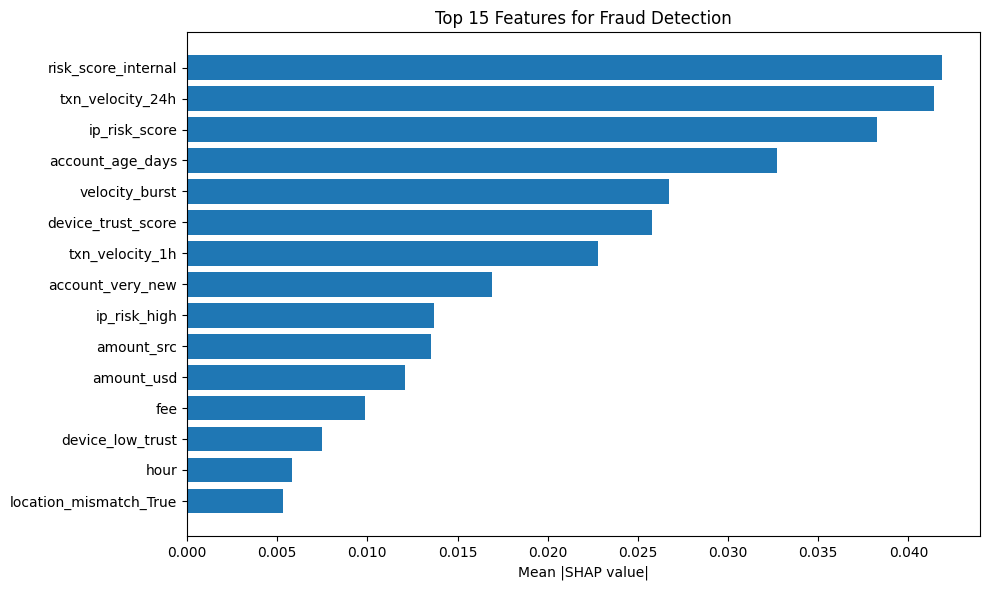

In [84]:
import matplotlib.pyplot as plt

# plot top 15
plt.figure(figsize=(10, 6))
top_15 = feature_importance.head(15)
plt.barh(range(len(top_15)), top_15['importance'])
plt.yticks(range(len(top_15)), top_15['feature'])
plt.xlabel('Mean |SHAP value|')
plt.title('Top 15 Features for Fraud Detection')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


Explainer_transaction Function